# <b> Задание </b>
Испытатели выставили дрон на некотором расстоянии от стены. Оператор запустил дрон и просто нажал на кнопку "лететь вперёд". При этом, есть определённый угол, на который траектория коптера отклоняется от стены. Каждый момент времени дрон меряет свою скорость `V` и расстояние до стены `h` с некоторой погрешностью. Необходимо определить угол, на который отклоняется дрон от стены.  

<p align="center"><img src="https://drive.google.com/uc?export=view&id=1QZMs7IHv5LR7RmJPVm1lslCg2c75oHxT"> </p>

## Цель
Получить практические навыки в использовании фильтра Калмана
## Задача
Определить угол смещения траектории дрона, летящего вдоль стены.


# <b> Ход работы </b>
<!-- 1 <span style='color:#FF6600de'>|</span> -->


## 1 <span style='color:#FF6600de'>|</span> Дифференциальная модель системы

`Before we start...`  
Поскольку нас просят найти лишь УГОЛ отклонения, задачу целесообразно решать простой регрессией типа метода наименьших квадратов, но так как цель в том, чтобы научиться работать с фильтром Калмана, будем составлять дифференциальную модель и необходимые матрицы.

Задачу можно реашать различными способами, в зависимости от того, что фильтруем:
- угол отклонения ($\alpha$)
- координаты дрона ($x$, $y$)
- измерения: скорость и расстояние

И вроде бы, вариант с углом кажется более привлекательным (так как одномерен), но, в сущности, имеем сложности с интерпретацией угловой скорости (мне не понятно, какую величину в такой модели брать в качестве радиуса).   
Затем я реализовал второй способ -- но, как оказалось, неверно.  
И вот я пришёл к третьему варианту (не без помощи преподавателя)

Следует отметить, что фильтровать нужно не просто расстояние до стены, а ещё и константу, которая каждый раз прибавляется к расстоянию -- таким образом мы говорим модели о линейном характере изменения расстояния до стены. Чтобы чуть больше позсказать модели о мире, добавим и скорость изменения этого приращения (по заданию, оно равно нулю, но мы посмотрим, как ведёт себя система, если сказать ей учитывать нелинейность)

Исходя из известных данных, можно построить следующее систему, уписывающую модель (простите, но в этот раз я не успел нормально в LaTex оформить):

<p align="center"><img src="https://drive.google.com/uc?export=view&id=1uxXjKXgTG6Ekk3UaSkIgA7Q5Xgx7twHf"> </p>

$V_i$ и $V_{i-1}$ -- скорость на текущем и предыдущем шаге  
$a_i$ -- ускорение на текущем шаге (в идеале нулевое, если дрон двигается равномерно) -- внешнее воздействие  
$h_i$ и $h_{i-1}$ -- расстояние до стены на текущем и предыдущем шаге  
$c_i$ и $c_{i-1}$ -- приращение расстояния до стены на текущем предыдущем шаге (в идеале константа)  
$V_{c,i}$ -- скорость изменения приращения (ускорение приращения * dt) на текущем шаге (в идеале нулевое, если дрон двигается равномерно) -- внешнее воздействие  

Приведём к матричному виду (важно сказать, что шумов у приращения к высоте нет, так как это не измеряемая величина -- шумит измеритель расстояния)

<p align="center"><img src="https://drive.google.com/uc?export=view&id=1h5kFR906N7KnGJwiVxVzMn-O1R63m309"> </p>


<a name="model"></a>
Показания датчиков нам говорят лишь `линейную скорость` и `высоту`. Однако этой информации достаточно для определения координат дрона в каждый момент времени.

Выделим какой-нибудь промежуток времени $\Delta t$ и опишем модель на основе поведения дрона в это время:
- имеем точку A($x_{i-1}, y_{i-1}$) с показанием расстояния до стены $h_{i-1}$
- дрон летит в точку B($x_{i}, y_{i}$) с показанием высоты $h_{i}$ и показанием скорости $V_i$. Стоит отметить, что в точке B индекс у скорости именно `i` -- по определению скорости через производную координаты по времени: $v_i = \frac{S_i-S_{i-1}} {t_{i}-t_{i-1}}$

[Вернуться к функциям извлечения координат и угла, если вы пришли оттуда](#settings_funcs)
<!-- [Вернуться к тестированию, если вы пришли оттуда](#back2test) -->

<p align="center"><img src="https://drive.google.com/uc?export=view&id=18JvmfHSXxi7QgWPCSG_PoL0Zu9Co0fST"> </p>


<a name="settings"></a>
Далее несложно вычислить координаты и угол:
<p align="center"><img src="https://drive.google.com/uc?export=view&id=1vuFbZDMFhCKjVMz3-U8WgIm32_NKHpl1"> </p>

## 2 <span style='color:#FF6600de'>|</span> Реализация на Python 🐍

Импорт библиотек

In [ ]:
import numpy as np
from numpy import matmul as mm, transpose as T
from numpy.linalg import inv
from scipy import integrate

import matplotlib.pyplot as plt
from math import sin, cos

%matplotlib inline

В блокноте удобнее работать с глобальными переменными, чем с ООП -- инициализируем всё необходимое

In [ ]:
X = np.array([[]])       # вектор неизвестных (x y)
U = np.array([[]])       # вектор известных
F = np.array([[]])       # внешнее воздействие (F = m(a-g) -> a = (F+mg) / m)
G = np.array([[]])       # матрица для предыдущих априорных вычислений
P = np.array([[]])       # степень доверия состоянию
Q = np.array([[]])       # ковариация ошибок
Gamma = np.array([[]])   # матрица коэффициентов шума (сами шумы уже есть в наблюдении)
Z = np.array([[]])       # наблюдение
H = np.array([[]])       # связь X и Z
R = np.array([[]])       # ковариация ошибки измерений

dotNum = 100
maxTime = 10
offset = -2  # начальное расстояние дрона от стены
constant = 0 # значение приращения расстояния от стены
alpha = -45   # реальный угол наклона в градусах

ts = np.linspace(0.01, maxTime, dotNum) # времянной интервал

clearMagnitudes = np.array([[]]) # "чистые" координаты (без шумов)
vs = np.array([])                # оценки ФК скорости коптера
hs = np.array([])                # оценки ФК расстояния до стены
cs = np.array([])                # оценки ФК приращений расстояния до стены (в идеале const)
Ks = []                          # коэффициенты Калмана

trustModel = 1 # коэффициент степени доверия модели
additiveErrorFlag = False # флаг наличия аддитивной погрешности

Реализация ФК в виде функции представлена ниже. Функция возвращает:
- апостериорную оценку координат дрона
- апостериорную оценку степени доверия текущему состоянию
- коэффициент Калмана

In [ ]:
def kalman_filter(
    X=np.array([[]]),       # вектор неизвестных (x y)
    U=np.array([[]]),       # вектор известных
    F=np.array([[]]),       # внешнее воздействие (F = m(a-g) -> a = (F+mg) / m)
    G=np.array([[]]),       # матрица для предыдущих априорных вычислений
    P=np.array([[]]),       # степень доверия состоянию
    Q=np.array([[]]),       # ковариация ошибок
    Gamma=np.array([[]]),   # матрица коэффициентов шума (сами шумы уже есть в наблюдении)
    Z=np.array([[]]),       # наблюдение
    H=np.array([[]]),       # связь X и Z
    R=np.array([[]]),       # ковариация ошибки измерений
):

    # X^- = (F X) + (G U)
    Xprior = mm(F, X) + mm(G, U)
    # P^- = (F P^^ F^T) + (Gamma Q Gamma^-1)
    Pprior = mm(mm(F, P), T(F)) + mm(mm(Gamma, Q), T(Gamma))

    # y = Z - (H X)
    y = Z - mm(H, Xprior)

    # S = (H P H^T) + R
    S = mm(mm(H, Pprior), T(H)) + R
    K = mm(mm(Pprior, T(H)), inv(S))

    Xposterior = Xprior + mm(K, y)
    Pposterior = mm((np.eye(len(X)) - mm(K, H)), Pprior)

    return Xposterior, Pposterior, K

Функции, имитирующие внешнее воздействие -- по заданию, и ускорение, и скорость приращения расстояния равны нулю, но мы с этим поиграемся при тестировании

In [ ]:
def a(t): # в идеале имеем повномерную скорость перемещения дрона
    return 0.0

def Vc(t): # и, соответственно, равномерную скорость прирашения высоты
    return 0.0

Имитация чистых значений скорости, расстояния и его приращения (тоже поиграемся) в зависимости от заданного угла alpha

In [ ]:
def gen_clear_vhc():
    global ts
    ts = np.linspace(0.01, maxTime, dotNum)
    dt = ts[1]-ts[0]

    vs = np.ones((dotNum)) + a(ts)*ts

    AC = vs*dt
    CB = cs = AC * np.tan(np.deg2rad(alpha))

    hs = np.cumsum(cs) + np.ones(len(cs)) * offset

    return np.stack([vs, hs, cs], axis=-1)

<a name="settings_funcs"></a>
Функция извлечения координат и угла по треугольнику ([какой треугольник?](#model))

In [ ]:
def get_xys(vs, hs, cs):
    dt = ts[1]-ts[0]

    AC = vs*dt
    CB = cs
    AB = np.sqrt(AC**2 + CB**2)

    height = AC*CB / AB

    xs = np.cumsum(np.sqrt(AC**2 - height**2) * np.sign(AC))
    ys = hs
    return np.stack((xs, ys), axis=-1)

def get_angles(vs, hs, cs):
    dt = ts[1]-ts[0]

    AC = vs*dt
    CB = cs

    angles = np.rad2deg(np.arctan(CB/AC))
    anglesInfLocs = np.where(angles == np.nan)
    angles[anglesInfLocs] = np.zeros(len(anglesInfLocs))
    return angles

Генерируем матрицы коэффициентов

In [ ]:
def gen_model_matrices():
    global F, G, Gamma, Q, R

    dt = ts[1]-ts[0]

    F = np.array([
        [1, 0, 0],
        [0, 1, 1],
        [0, 0, 1],
    ])

    G = np.array([
        [dt, 0, 0],
        [0, dt, 0],
        [0, dt, 0],
    ])

    Gamma = np.array([
        [dt,  0, 0],
        [ 0, dt, 0],
        [ 0,  0, 0],
    ])

    Q = np.eye(3)
    R = np.eye(3) * trustModel # чем больше R, тем больше фильтр доверяет модели

Генерируем измерения и всё, что с ними связано:

In [ ]:
def gen_measurments():
    global clearMagnitudes, Z, H

    clearMagnitudes = gen_clear_vhc()

    additiveError = 0.3
    W = np.random.rand(3, len(ts)+1) * additiveError*2
    if not additiveErrorFlag:
        W -= np.ones(len(ts)+1) * additiveError

    Z = np.array([
        clearMagnitudes[:, 0] + W[0, :-1],
        clearMagnitudes[:, 1] + W[1, :-1],
        clearMagnitudes[:, 2] + W[1, 1:]-W[1, :-1],
    ])

    H = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ])

Итеративная фильтрация

In [ ]:
def play_filter():
    global vs, hs, cs, Ks

    Xi_1 = np.array([[Z[0][0]], [Z[1][0]], [Z[2][0]]])
    Pi_1 = np.eye(3)

    vs = [Xi_1[0][0]]
    hs = [Xi_1[1][0]]
    cs = [Xi_1[2][0]]
    Ks = []

    for i, t in enumerate(ts[1:], 1):
        Xi, Pi, K = kalman_filter(
            Xi_1,
            np.array([
                [a(t)],
                [Vc(t)],
                [0],
            ]),
            F, G, Pi_1, Q, Gamma,
            np.array([
                [Z[0, i]],
                [Z[1, i]],
                [Z[2, i]],
            ]),
            H, R
        )

        vs.append(Xi[0][0])
        hs.append(Xi[1][0])
        cs.append(Xi[2][0])
        Ks.append(K)

        Xi_1 = np.copy(Xi)
        Pi_1 = np.copy(Pi)

    vs = np.array(vs)
    hs = np.array(hs)
    cs = np.array(cs)
    Ks = np.array(Ks)

Графики для наглядности

In [ ]:
def plt_trajectory():
    '''
    Графики скорости, расстояния до стены, траектории полёта дрона и угла смещения траектории:
    - построенные по измерениям датчиков
    - истинные
    - отфильтрованные ФК
    '''
    dt = ts[1]-ts[0]

    clearXys = get_xys(*clearMagnitudes.T)
    clearAngles = get_angles(*clearMagnitudes.T)

    measuredXys = get_xys(Z[0], Z[1], Z[2])
    measuredAngles = get_angles(Z[0], Z[1], Z[2])

    xys = get_xys(vs, hs, cs)
    angles = get_angles(vs, hs, cs)

    wallLen = np.max((*clearXys[:, 0], *measuredXys[:, 0]))
    wall = np.array([[0, 0], [wallLen, 0]])

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[10, 10])

    ax[0][0].set(title='Скорость движения')
    ax[0][0].plot(
        ts[0:], Z[0], '--',
        ts[0:], clearMagnitudes[:, 0], 'r',
        ts[0:], vs,
    )
    ax[0][0].legend([
        'Измерения датчиков',
        'Реальная скорость',
        'Результат работы ФК',
    ])
    ax[0][0].grid()

    ax[0][1].set(title='Расстояние до стены')
    ax[0][1].plot(
        ts[0:], Z[1], '--',
        ts[0:], clearMagnitudes[:, 1], 'r',
        ts[0:], hs,
    )
    ax[0][1].legend([
        'Измерения датчиков',
        'Реальное расстояние',
        'Результат работы ФК',
    ])
    ax[0][1].grid()


    ax[1][0].set(title='Траектория движения')
    ax[1][0].plot(
        measuredXys[:, 0], measuredXys[:, 1], '--',
        clearXys[:, 0], clearXys[:, 1], 'r',
        xys[:, 0], xys[:, 1]
    )
    ax[1][0].plot(wall[:, 0], wall[:, 1], linewidth=10)
    ax[1][0].legend([
        'Измерения датчиков',
        'Реальная траектория',
        'Результат работы ФК',
        'Стена',
    ])
    ax[1][0].grid()


    ax[1][1].set(title='Угол наклона')
    ax[1][1].plot(
        ts[0:], measuredAngles, '--',
        ts[0:], clearAngles, 'r',
        ts[0:], angles,
    )
    ax[1][1].legend([
        'Измерения датчиков',
        'Реальный угол',
        'Результат работы ФК',
    ])
    ax[1][1].grid()

    plt.show()

def plt_Ks():
    '''Построение графика изменений коэффициента Калмана'''
    plt.figure(2)

    fig, ax = plt.subplots(figsize=[10, 4])
    ax.set(title='Коэффициент Калмана')
    ax.plot(
        ts[1:], Ks[:, 0, 0],
        ts[1:], Ks[:, 1, 1],
        ts[1:], Ks[:, 2, 2],
    )
    ax.legend([
        'Скорость',
        'Расстояние до стены',
        'Приращение расстояния до стены',
    ])
    ax.grid()
    plt.show()

Мэйн для удобства

In [ ]:
def main():
    gen_model_matrices()
    gen_measurments()
    play_filter()
    plt_trajectory()
    plt_Ks()

## 3 <span style='color:#FF6600de'>|</span> Тестирование

Сначала с дефолтными параметрами

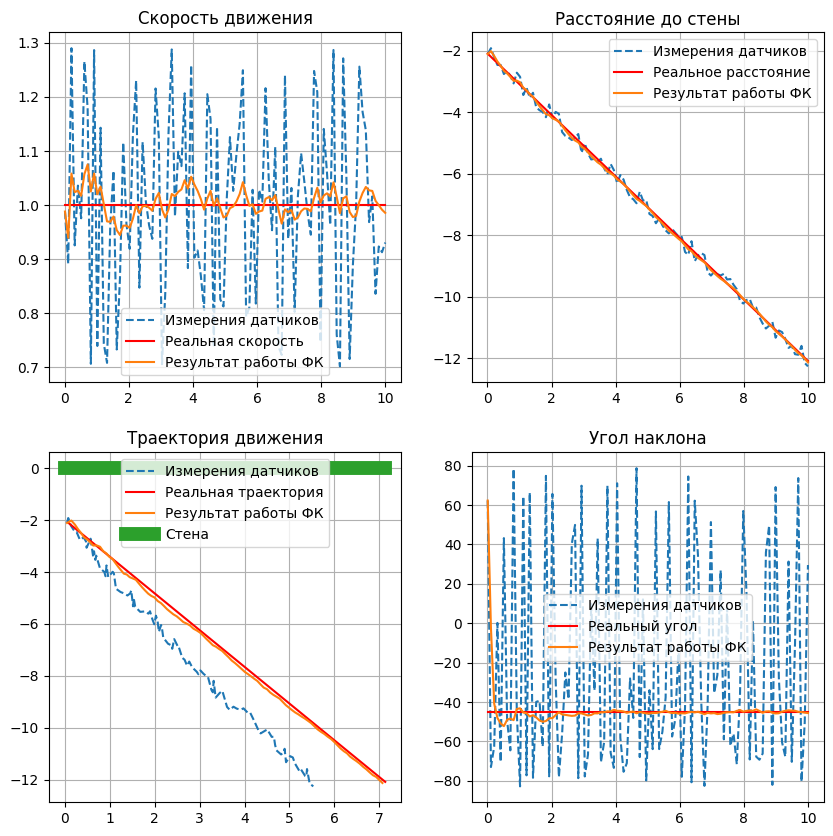

<Figure size 640x480 with 0 Axes>

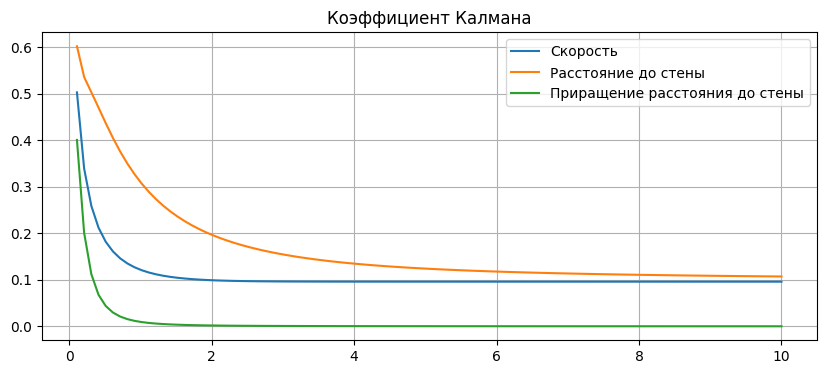

In [ ]:
trustModel = 1
dotNum = 100
main()

Видим, что коэффийиент Калмана сходится -- модель описана верно.

Оценка угла не плоха, но фильтрация скорости выглядит плохо. Примечательно, что траектория, расчитанная по измерениям, выглядит совершенно непохожей на реальную траекторию -- так происходит потому, что модель фильтрует не координаты, а измерения. Ошибку мы вносим в измерения скорости и расстояния -- но координаты будут получены либо вычитанием (y), либо возведением в квадрат, суммированием и извлечением корня (x) -- тут шумы сильно влияют на результат. Так что, имеем страекторию странного вида.

Но даже насмотря на это, отфильтрованные координаты довольно точны (с точностью до угла, но раз только он нам и нужен, то можно не париться по траектории)

Повысим уровень доверия модели

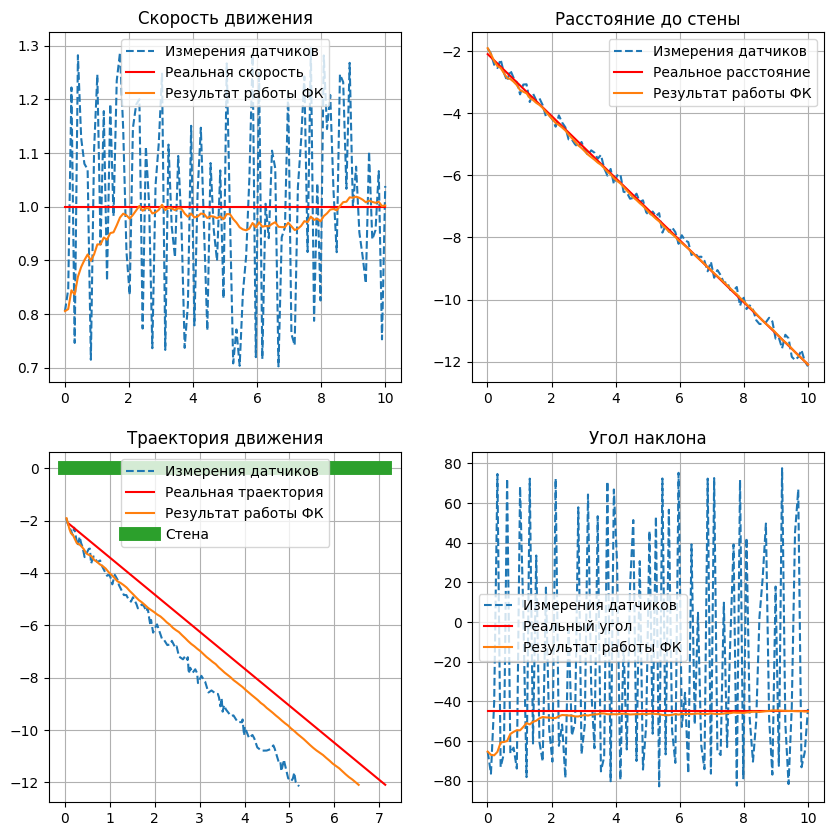

<Figure size 640x480 with 0 Axes>

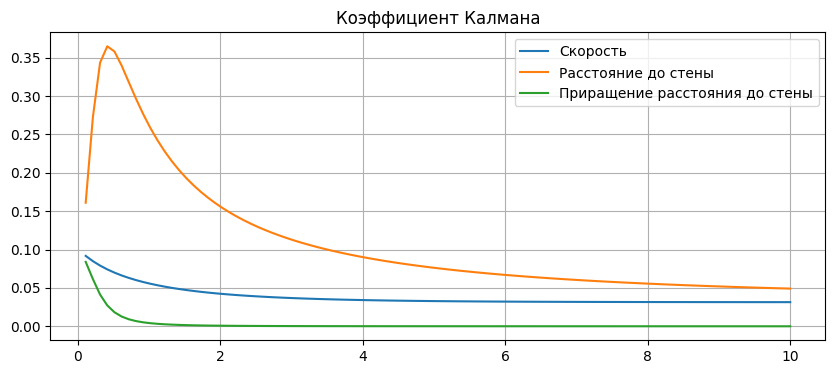

In [ ]:
trustModel = 10
main()

Неплохо, но скорость не успела установиться -- ещё увеличим доверие и количество измерений

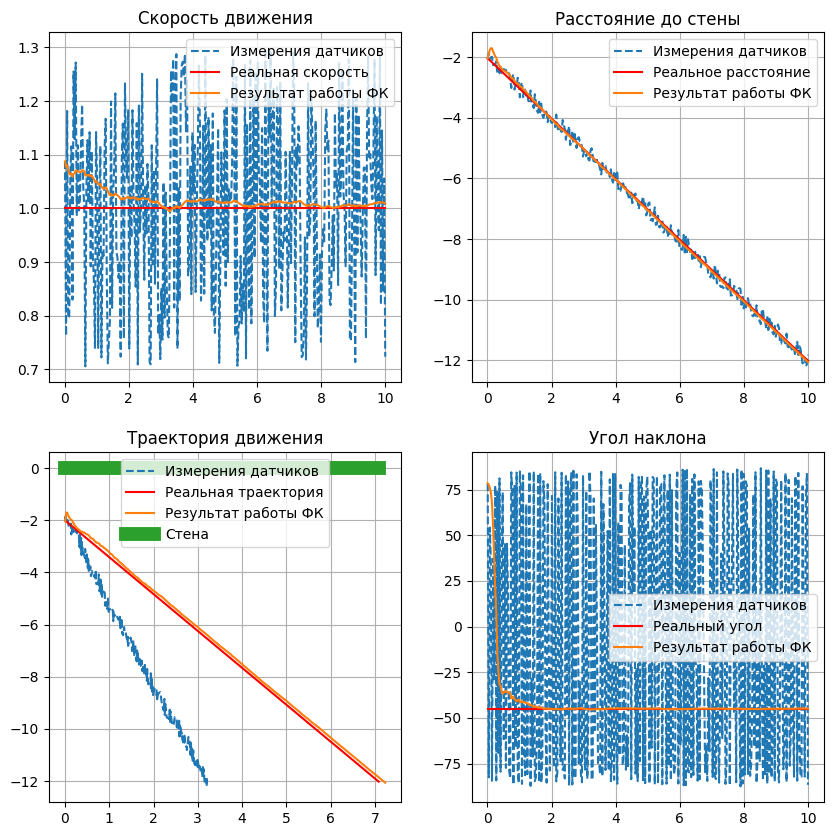

<Figure size 640x480 with 0 Axes>

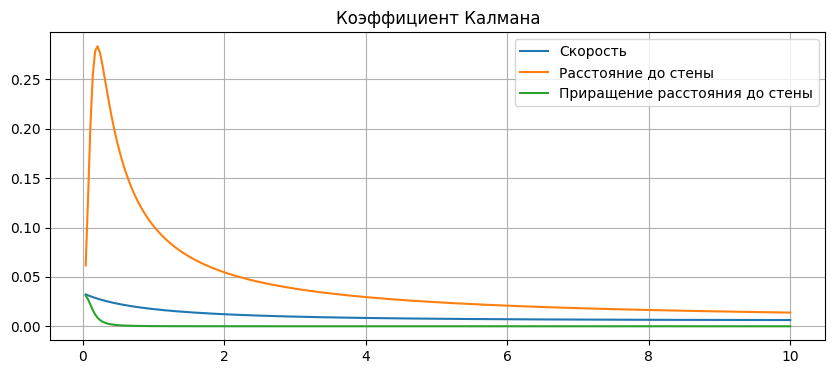

In [ ]:
trustModel = 30
dotNum = 300
main()

Отличные результаты. А теперь будем играться с параметрами данных


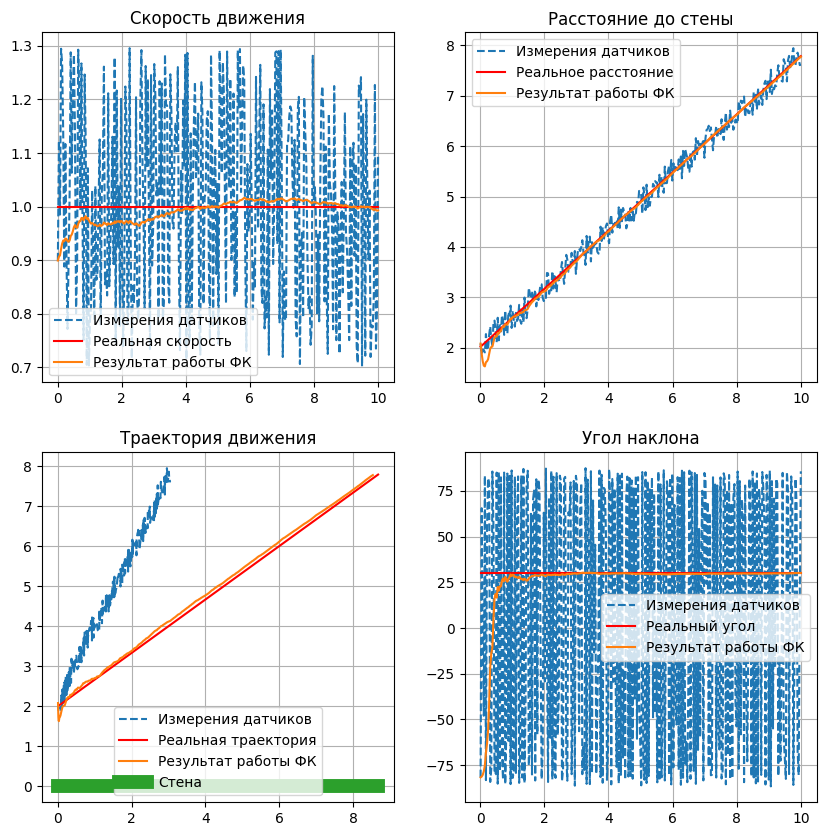

<Figure size 640x480 with 0 Axes>

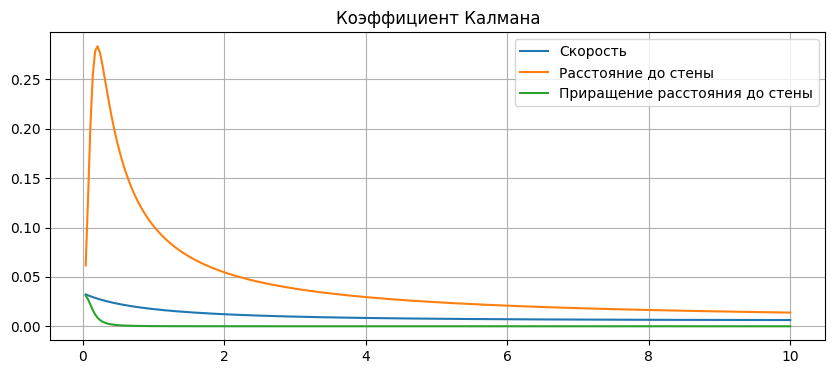

In [ ]:
offset = 2
alpha = 30
main()

Попробуем теперь поиграться с нелинейностью показаний датчиков

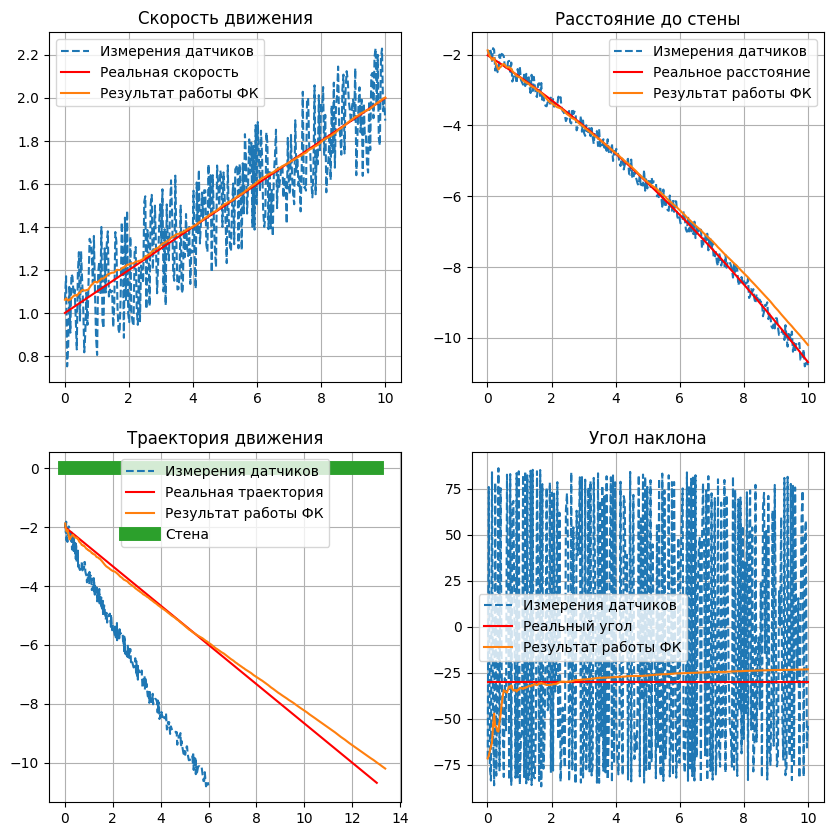

<Figure size 640x480 with 0 Axes>

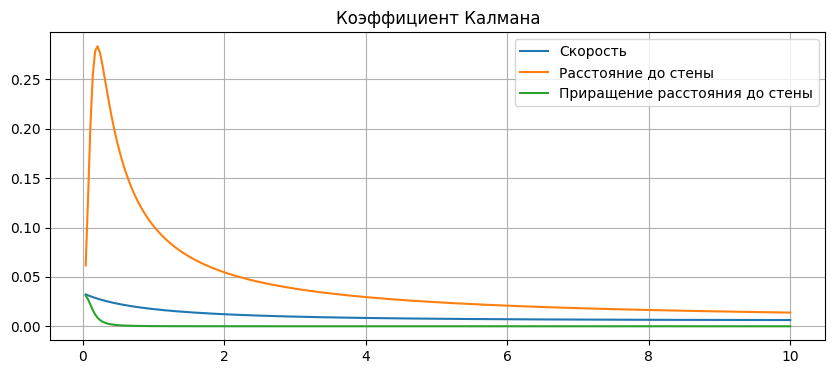

In [ ]:
def a(t): # в идеале имеем повномерную скорость перемещения дрона
    return 0.1

def Vc(t): # и, соответственно, равномерную скорость прирашения высоты
    return 0.0


offset = -2
alpha = -30
main()

# <b>Выводы</b>

В ходе данной лабораторной работы мною были получены практические навыки в работе с фильтром Калмана:
- реализован ФК
- описана модель в виде системы
- модель реализована на Python
- все выкладки протестированы и объяснены

Также возникли следующие трудности:
- не удалось составить модель, в которой в качестве неизвестной выступает угол наклона (неясно, что брать за радиус в определении угловой скорости -- т.е. как перевести линейную скорость в угловую)
- изначально пошёл по пути фильтрации координат и получил довольно бесполезный фильтр -- не зная, какие должны быть нешумные значения скорости и расстояния, такому фильтру сложно оценить угол...
- текущая модель хороша для линейной скорости, если скорость нелинейная -- моделировть Vc и a сложно (одно зависит от другого)

Помимо этого, оказалось, что простым SSE не обойтись -- шумные показания скорости сильно сбивают угол наклона -- это хорошо видно на графике траектории полёта